# Homework 2 - balancing & binning (deadline 28. 11. 2020)

In short, the main task is to play with balancing and binning to obtain the best results for the binary classification task.
  
> The instructions are not given in details: It is up to you to come up with ideas on how to fulfill the particular tasks as best you can!

## What are you supposed to do:

  1. Download the dataset [here](https://www.dropbox.com/s/aq08ytozfplb97b/data.csv?dl=0).
  1. Use 2 binning methods (on features of your choice, with your choice of parameters) and comment on its effects on classification performance.
  1. Use at least 2 other data balancing techniques of your choice on the dataset and comment the classification results. **Just copied code from tutorial 4 will not be accepted.**
  1. Run all classification tests at least three times - once for unbalanced original data, twice for balanced data (try at least 2 balancing techniques), compare those results (give a comment).
  
Give comments (!) on each step of your solution, with short explanations of your choices.

**If you do all this properly, you will obtain 16 points.** 

## Comments

  * Please follow the instructions from https://courses.fit.cvut.cz/MI-PDD/homeworks/index.html.
  * If the reviewing teacher is not satisfied, she can (!) give you another chance to rework your homework and to obtain more points. However, this is not a given, so do your best! :)
  * English is not compulsory.
  
## Data description

* The dataset can be downloaded [here](https://www.dropbox.com/s/aq08ytozfplb97b/data.csv?dl=0).
* The data are devoted to the binary classification task, the aim is to predict the probability that a driver will initiate an auto insurance claim in the next year.
* Target feature is called 'y' and signifies whether or not a claim was filed for that policy holder.
* To fulfill the task one does not need to know the meaning of predictors.
* Predictors that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation.
* While using [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), control the shuffling of data by random_state parameter. Do not use shuffle=False, probably never (can cause systematic error).

## 1) Importy a příprava dat
 * Nejprve načteme data a zobrazíme si základní informace. (#1.1)
 * Následně jsou všechny příznaky datového typu int64 převedeny na float64. (#1.2)
 * Před použitím škatulkovacích a vyvažovacích metod je třeba rozdělit data na trénovací a testovací množinu (případně by šlo použít i validační). Trénovací data tvoří 75% datasetu, testovací 25%. (#1.3)
 * Následně je provedena MinMax standardizace dat (#1.4) a jsou odstraněny příznaky, u kterých se předpokládá, že mají na predikci nejmenší vliv (konstatní příznaky (#1.5), příznaky s nízkým rozptylem (#1.6) a příznaky s nízkou korelací  určenou pomocí Pearsonovi metody (#1.7)). 

In [1]:
#1.1
import numpy as np
import pandas as pd
import warnings
from pandas.core.common import SettingWithCopyWarning
from scipy.optimize import minimize_scalar
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NeighbourhoodCleaningRule
import itertools
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data.csv',sep=',') 

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 58 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   y             595212 non-null  int64  
 1   xind_01       595212 non-null  int64  
 2   xind_02_cat   595212 non-null  int64  
 3   xind_03       595212 non-null  int64  
 4   xind_04_cat   595212 non-null  int64  
 5   xind_05_cat   595212 non-null  int64  
 6   xind_06_bin   595212 non-null  int64  
 7   xind_07_bin   595212 non-null  int64  
 8   xind_08_bin   595212 non-null  int64  
 9   xind_09_bin   595212 non-null  int64  
 10  xind_10_bin   595212 non-null  int64  
 11  xind_11_bin   595212 non-null  int64  
 12  xind_12_bin   595212 non-null  int64  
 13  xind_13_bin   595212 non-null  int64  
 14  xind_14       595212 non-null  int64  
 15  xind_15       595212 non-null  int64  
 16  xind_16_bin   595212 non-null  int64  
 17  xind_17_bin   595212 non-null  int64  
 18  xind

In [4]:
#1.2
data = pd.get_dummies(data)
data[data.select_dtypes(['float64', 'int64']).columns] = data[data.select_dtypes(['float64', 'int64']).columns].astype('float64')

In [5]:
#1.3
y = list(data['y']).copy()
X = data.drop(['y'], axis=1).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=13)

In [6]:
#1.4
minmax_scaler = preprocessing.MinMaxScaler()
columns = X_train.select_dtypes(include=['float64']).columns 
minmax_scaler.fit(X_train[columns])
XS_train = X_train.copy()
XS_test = X_test.copy()
XS_train[columns] = minmax_scaler.transform(X_train[columns])
XS_test[columns] = minmax_scaler.transform(X_test[columns])
XS_train.head()

,xind_01,xind_02_cat,xind_03,xind_04_cat,xind_05_cat,xind_06_bin,xind_07_bin,xind_08_bin,xind_09_bin,xind_10_bin,...,xcalc_11,xcalc_12,xcalc_13,xcalc_14,xcalc_15_bin,xcalc_16_bin,xcalc_17_bin,xcalc_18_bin,xcalc_19_bin,xcalc_20_bin
81638,0.857143,0.4,0.727273,1.0,0.142857,0.0,0.0,1.0,0.0,0.0,...,0.263158,0.0,0.307692,0.304348,0.0,1.0,0.0,0.0,0.0,0.0
566900,0.285714,0.4,0.545455,0.5,0.142857,1.0,0.0,0.0,0.0,0.0,...,0.052632,0.3,0.307692,0.304348,0.0,0.0,0.0,0.0,0.0,0.0
467874,0.000000,0.4,0.181818,0.5,0.142857,1.0,0.0,0.0,0.0,0.0,...,0.421053,0.2,0.230769,0.347826,0.0,1.0,0.0,1.0,1.0,0.0
198969,0.285714,0.6,0.181818,1.0,0.142857,0.0,0.0,1.0,0.0,0.0,...,0.368421,0.3,0.000000,0.347826,0.0,0.0,0.0,0.0,1.0,0.0
489542,0.000000,0.4,0.363636,1.0,0.142857,1.0,0.0,0.0,0.0,0.0,...,0.263158,0.2,0.076923,0.434783,0.0,1.0,0.0,0.0,0.0,0.0


In [7]:
#1.5
display(XS_train.columns[XS_train.min() == XS_train.max()])

Index([], dtype='object')

In [8]:
#1.6
columns_to_remove = list(set(list(XS_train.columns[XS_train.var() < 0.035]))) 
print(XS_train[columns_to_remove].var().nlargest(60))
print(len(columns_to_remove))

xcalc_09       0.031666
xcar_07_cat    0.030165
xreg_03        0.024782
xcalc_07       0.024707
xcalc_06       0.021955
xcalc_08       0.021242
xind_02_cat    0.017650
xcalc_13       0.016974
xcalc_11       0.015089
xcalc_12       0.014471
xcalc_14       0.014268
xcalc_10       0.013520
xind_12_bin    0.009333
xcar_13        0.004197
xcar_10_cat    0.002101
xind_11_bin    0.001695
xind_14        0.001011
xind_13_bin    0.000871
xcar_12        0.000664
xind_10_bin    0.000369
dtype: float64
20


In [9]:
#1.7
XYS_train = XS_train
XYS_train['y'] = y_train
corrP = XYS_train.drop(columns_to_remove, axis = 1, errors = 'ignore').corr(method='pearson')
corrP_cols = corrP.y.abs().nlargest(10).index
display(corrP.y.loc[corrP_cols])

y              1.000000
xind_17_bin    0.036463
xreg_02        0.034607
xind_06_bin   -0.034428
xind_07_bin    0.033496
xcar_03_cat    0.032286
xcar_04_cat    0.032050
xcar_02_cat   -0.031932
xind_05_cat    0.029212
xcar_15        0.027515
Name: y, dtype: float64

In [10]:
other_columns_to_remove = list(corrP.y[corrP.y.abs() < 0.005].index)
print(other_columns_to_remove)

['xind_18_bin', 'xcar_11', 'xcalc_01', 'xcalc_02', 'xcalc_03', 'xcalc_04', 'xcalc_05', 'xcalc_15_bin', 'xcalc_16_bin', 'xcalc_17_bin', 'xcalc_18_bin', 'xcalc_19_bin', 'xcalc_20_bin']


In [11]:
XS_train = XS_train.drop(columns_to_remove, axis = 1, errors = 'ignore')
XS_test = XS_test.drop(columns_to_remove, axis = 1, errors = 'ignore')
XS_train = XS_train.drop(other_columns_to_remove, axis = 1, errors = 'ignore')
XS_test = XS_test.drop(other_columns_to_remove, axis = 1, errors = 'ignore')
XS_train = XS_train.drop(['y'], axis=1)

In [12]:
print("Nový počet příznaků:")
print(len(XS_train.columns))

Nový počet příznaků:
24


# 2) Škatulkovací metody

  * Nejprve je potřeba zvolit příznaky, podle kterých budou následně vytvořeny jednotlivé intervaly. Tyto příznaky by neměly obsahovat příliš mnoho chybějících hodnot. Z prvního výstupu (#2.1) si však můžeme všimnout, že tabulka žádné chybějící hodnoty neobsahuje, alespoň ne v podobě NaN. Dále by nám ve volbě mohly pomoci histogramy. Pro každý příznak byl tedy vykreslen histogram (#2.2). Příznak 'xreg_02' by podle Pearsonovi metody pro určení korelace s predikovanou hodnotou měl mít velký vliv na predikci, proto tento příznak můžeme zkusit zvolit pro škatulkovací metody. Histogram pro tento příznak vypadá celkem přijatelně. Dalším příznakem s relativně přijatelným histogramem je příznak 'xind_15', ten má celkem zajímavé rozdělení. Ve spoustě histogramů si můžeme všimnout malého počtu "sloupců", takové příznaky nejsou přiliš vyhovující. Použijeme tedy příznaky 'xreg_02' a 'xind_15'.
  * Dále je třeba zvolit jednotlivé intervaly. Obecně platí pravidlo, že intervalů by nemělo být méně než klasifikačních tříd. Podle histogramů byla zvolena hodnota 7. Poté jsou k dispozici dvě základní metody. Jedna je založena na principu intervalů stejného rozsahu (ekvidistanční intervaly), druhá na principu intervalů se stejným počtem prvků (ekvifrekvenčních intervaly). Pro nalezení intervalů byly použity funkce cut a qcut (#2.3). Tyto funkce však byly použity pouze na trénovací množinu dat, testovací použita nebyla. 
  * V předchozím bodu bylo řešeno pouze nalezení intervalů. Následně je potřeba zavést nové příznaky týkající se jednotlivých škatulek ('WBin_xreg_02', 'WBin_xind_15', 'DBin_xreg_02', 'DBin_xind_15') do trénovacího a testovacího datasetu. (#2.4)
  * V části (#2.5) jsou vykreselny histogramy pro oba příznaky a pro ně vytvořené škatulky.
  * Následně jsou naše nová data použita pro klasifikační modely (#2.6). Pro porovnání jsou nejprve použita původní data a poté data obohacená o nový příznak (postupně nové příznaky 'WBin_xreg_02', 'WBin_xind_15', 'DBin_xreg_02', 'DBin_xind_15'). Jako klasifikační modely byly zvoleny: rozhodovací strom, náhodný les, AdaBoost, MLP - neuronové sítě, Gaussův naivní Bayes, Bernoulliho naivní Bayes a kvadratická diskriminační analýza. Jednotlivé výsledky můžeme najít ve výstupu sekce (#2.6). Můžeme si všimnout, že zavedení jednotlivých škatulkových metod nemělo příliš velký úspěch, ba naopak v mnoha případech je nepatrně lepší klasifikační model založený na původních datech. Jednou z příčin může být příliš vysoký počet příznaků v datasetu. U takového datasetu se dá předpokládat, že jeden nový příznak přesnost modelu příliš neovlivní.

In [13]:
#2.1
print("Počet příznaků, které obsahují chybějící hodnoty:")
len(XS_train.columns[XS_train.isnull().any()])

Počet příznaků, které obsahují chybějící hodnoty:


0

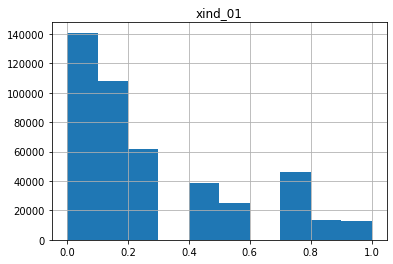

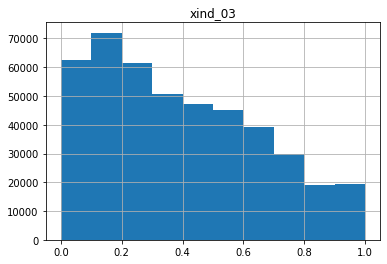

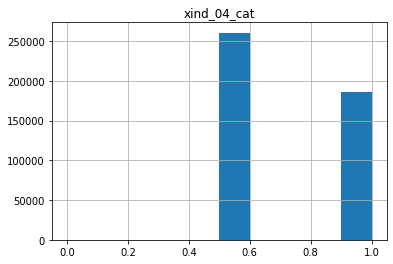

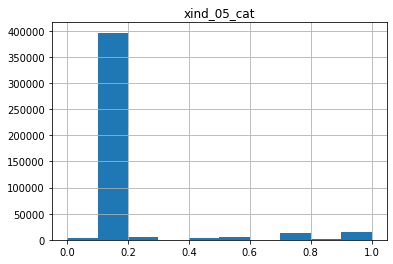

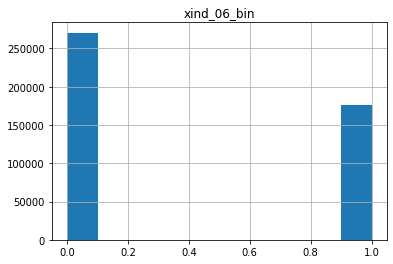

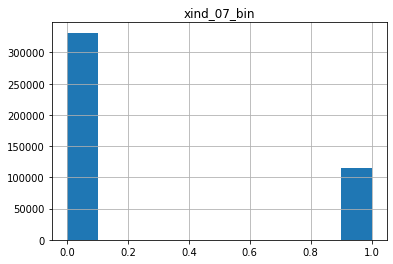

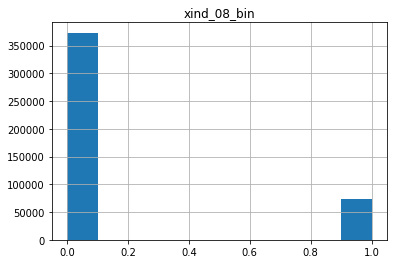

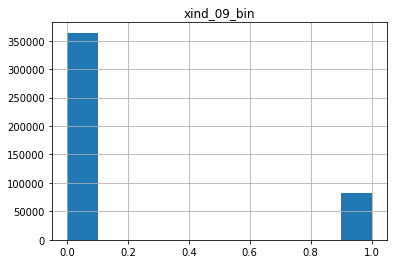

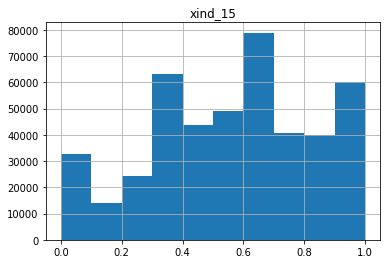

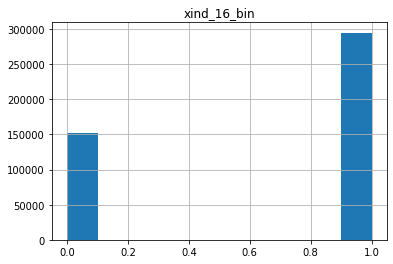

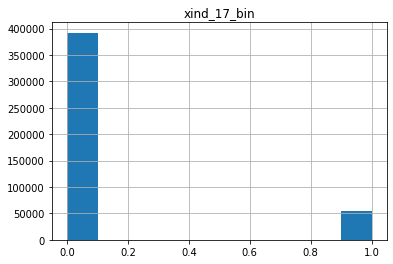

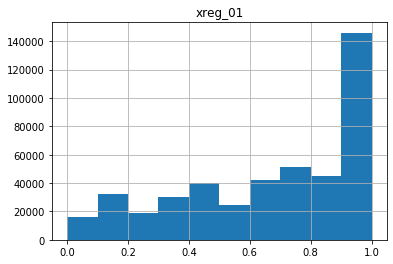

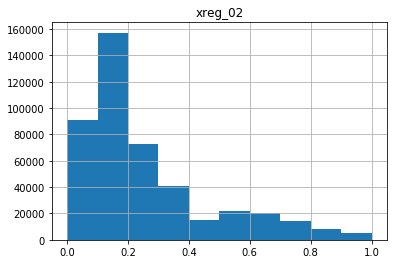

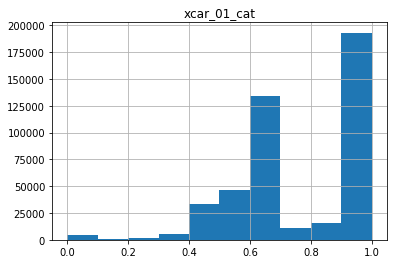

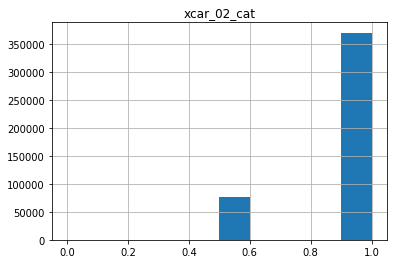

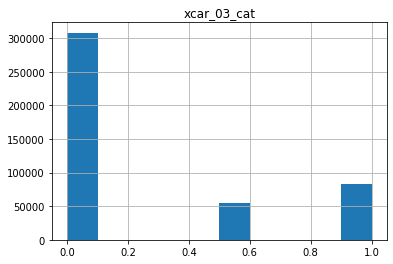

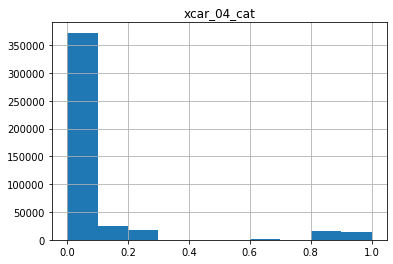

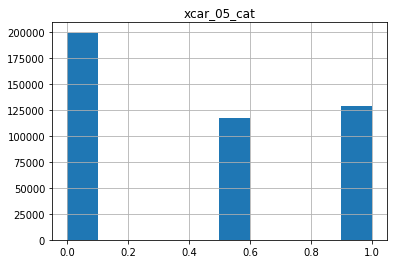

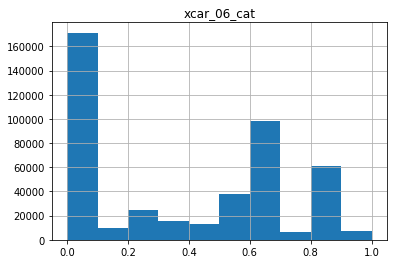

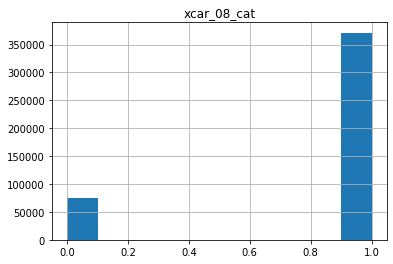

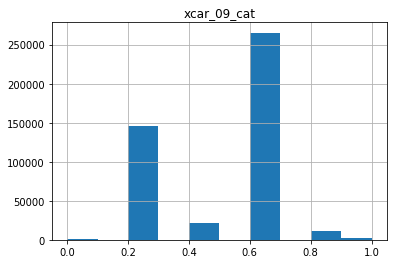

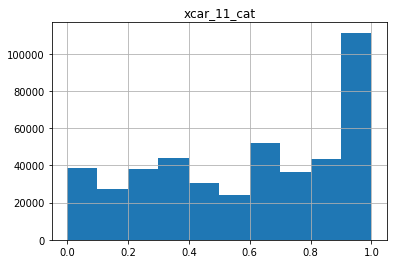

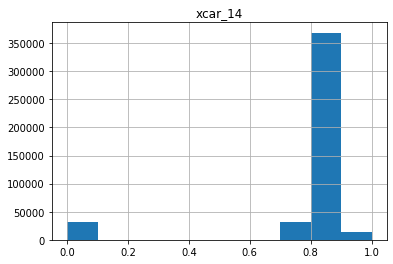

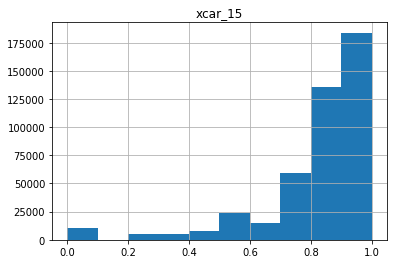

In [14]:
#2.2
for col in XS_train.columns:
    XS_train[[col]].hist()

In [15]:
#2.3
def selectBinForValue( inValue, inBins ):
    for i in range(1, inBins.size ):
        if inValue < inBins[i] :
            return i
    return inBins.size

In [16]:
_, binsW1 = pd.cut(XS_train['xreg_02'], 6, retbins=True)
binsW1 = np.concatenate(([-np.inf], binsW1[1:-1], [np.inf]))
_, binsW2 = pd.cut(XS_train['xind_15'], 7, retbins=True)
binsW2 = np.concatenate(([-np.inf], binsW2[1:-1], [np.inf]))
_, binsD1 = pd.qcut(XS_train['xreg_02'], 6, retbins=True)
binsD1 = np.concatenate(([-np.inf], binsD1[1:-1], [np.inf]))
_, binsD2 = pd.qcut(XS_train['xind_15'], 7, retbins=True)
binsD2 = np.concatenate(([-np.inf], binsD2[1:-1], [np.inf]))

print("Hraniční body jednotlivých ekvidistančních intervalů pro příznak xreg_02:")
print(binsW1)
print("")
print("Hraniční body jednotlivých ekvidistančních intervalů pro příznak xind_15:")
print(binsW2)
print("")
print("Hraniční body jednotlivých ekvifrekvenčních intervalů pro příznak xreg_02:")
print(binsD1)
print("")
print("Hraniční body jednotlivých ekvifrekvenčních intervalů pro příznak xind_15:")
print(binsD2)

Hraniční body jednotlivých ekvidistančních intervalů pro příznak xreg_02:
[      -inf 0.16666667 0.33333333 0.5        0.66666667 0.83333333
        inf]

Hraniční body jednotlivých ekvidistančních intervalů pro příznak xind_15:
[      -inf 0.14285714 0.28571429 0.42857143 0.57142857 0.71428571
 0.85714286        inf]

Hraniční body jednotlivých ekvifrekvenčních intervalů pro příznak xreg_02:
[      -inf 0.05555556 0.11111111 0.16666667 0.27777778 0.44444444
        inf]

Hraniční body jednotlivých ekvifrekvenčních intervalů pro příznak xind_15:
[      -inf 0.23076923 0.38461538 0.53846154 0.61538462 0.76923077
 0.84615385        inf]


In [17]:
#2.4
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
XS_train['WBin_xreg_02'] = XS_train.apply(lambda v: selectBinForValue( v['xreg_02'], binsW1), axis=1)
XS_test['WBin_xreg_02'] = XS_test.apply(lambda v: selectBinForValue( v['xreg_02'], binsW1), axis=1)

XS_train['WBin_xind_15'] = XS_train.apply(lambda v: selectBinForValue( v['xind_15'], binsW2), axis=1)
XS_test['WBin_xind_15'] = XS_test.apply(lambda v: selectBinForValue( v['xind_15'], binsW2), axis=1)

XS_train['DBin_xreg_02'] = XS_train.apply(lambda v: selectBinForValue( v['xreg_02'], binsD1), axis=1)
XS_test['DBin_xreg_02'] = XS_test.apply(lambda v: selectBinForValue( v['xreg_02'], binsD1), axis=1)

XS_train['DBin_xind_15'] = XS_train.apply(lambda v: selectBinForValue( v['xind_15'], binsD2), axis=1)
XS_test['DBin_xind_15'] = XS_test.apply(lambda v: selectBinForValue( v['xind_15'], binsD2), axis=1)

In [18]:
XS_train[['xreg_02', 'xind_15', 'xreg_02', 'xind_15', 'WBin_xreg_02', 'WBin_xind_15', 'DBin_xreg_02', 'DBin_xind_15']]

,xreg_02,xind_15,xreg_02,xind_15,WBin_xreg_02,WBin_xind_15,DBin_xreg_02,DBin_xind_15
81638,0.166667,0.384615,0.166667,0.384615,2,3,4,3
566900,0.166667,0.846154,0.166667,0.846154,2,6,4,7
467874,0.500000,0.538462,0.500000,0.538462,4,4,6,4
198969,0.111111,0.923077,0.111111,0.923077,1,7,3,7
489542,0.111111,0.538462,0.111111,0.538462,1,4,3,4
...,...,...,...,...,...,...,...,...
344035,0.166667,0.384615,0.166667,0.384615,2,3,4,3
167866,0.111111,0.846154,0.111111,0.846154,1,6,3,7
256742,0.166667,0.615385,0.166667,0.615385,2,5,4,5
253456,1.000000,0.846154,1.000000,0.846154,6,6,6,7


In [19]:
XS_test[['xreg_02', 'xind_15', 'xreg_02', 'xind_15', 'WBin_xreg_02', 'WBin_xind_15', 'DBin_xreg_02', 'DBin_xind_15']]

,xreg_02,xind_15,xreg_02,xind_15,WBin_xreg_02,WBin_xind_15,DBin_xreg_02,DBin_xind_15
240034,0.222222,0.000000,0.222222,0.000000,2,1,4,1
122822,0.333333,0.769231,0.333333,0.769231,3,6,5,6
242279,0.111111,0.615385,0.111111,0.615385,1,5,3,5
594193,0.111111,0.230769,0.111111,0.230769,1,2,3,2
146126,0.000000,0.384615,0.000000,0.384615,1,3,1,3
...,...,...,...,...,...,...,...,...
492175,0.333333,0.230769,0.333333,0.230769,3,2,5,2
333191,0.166667,0.461538,0.166667,0.461538,2,4,4,3
320254,0.611111,0.230769,0.611111,0.230769,4,2,6,2
391437,0.111111,0.307692,0.111111,0.307692,1,3,3,2


xreg_02 - ekvidistanční intervaly - histogram:


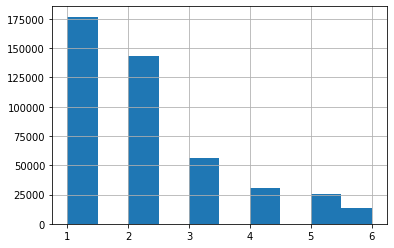

In [20]:
#2.5
print( "xreg_02 - ekvidistanční intervaly - histogram:")
XS_train['WBin_xreg_02'].hist()

xreg_02 - ekvifrekvenční intervaly - histogram:


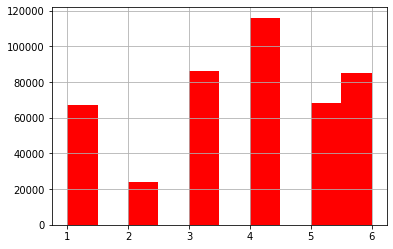

In [21]:
print( "xreg_02 - ekvifrekvenční intervaly - histogram:")
XS_train['DBin_xreg_02'].hist(color='red')

xind_15 - ekvidistanční intervaly - histogram:


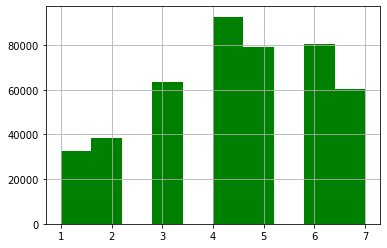

In [22]:
print( "xind_15 - ekvidistanční intervaly - histogram:")
XS_train['WBin_xind_15'].hist(color='green')

xind_15 - ekvifrekvenční intervaly - histogram:


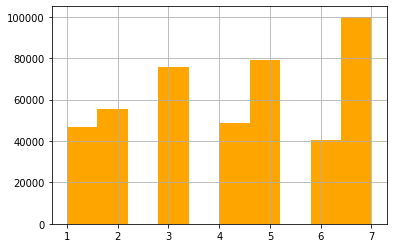

In [23]:
print( "xind_15 - ekvifrekvenční intervaly - histogram:")
XS_train['DBin_xind_15'].hist(color='orange')

In [24]:
#2.6
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    MLPClassifier(alpha=5),
    GaussianNB(),
    BernoulliNB(),
    QuadraticDiscriminantAnalysis()]

names = [
    "Rozhodovací strom",
    "Náhodný les",
    "AdaBoost",
    "MLP - Neurovnové sítě",
    "Gaussovský naivní Bayes",
    "Bernoulliho naivní Bayes",
    "Kvadratická diskriminační analýza"]

scoresOriginal = np.zeros(len(names))
scoresWBinXREG2 = np.zeros(len(names))
scoresWBinXIND15 = np.zeros(len(names))
scoresDBinXREG2 = np.zeros(len(names))
scoresDBinXIND15 = np.zeros(len(names))


print( "==================Původní data===================")
for i in range( len( names ) ):
    clf = classifiers[i]
    XX_train = XS_train.drop(['WBin_xreg_02', 'WBin_xind_15', 'DBin_xreg_02', 'DBin_xind_15'], axis=1)
    XX_test = XS_test.drop(['WBin_xreg_02', 'WBin_xind_15', 'DBin_xreg_02', 'DBin_xind_15'], axis=1)
    y_pred = clf.fit(XX_train, y_train).predict(XX_test)
    scoresOriginal[i] = accuracy_score(y_test, y_pred)
    print('\nMetoda: ', names[i], '\nSkóre: ', scoresOriginal[i] )
print( "\n------------------------------------------------")
print("\nPrůměrné skóre: ", np.sum(scoresOriginal) / len(names), "\n" )
print( "=======xreg_02 - ekvidistanční intervaly========")
for i in range( len( names ) ):
    clf = classifiers[i]
    XX_train = XS_train.drop(['WBin_xind_15', 'DBin_xreg_02', 'DBin_xind_15'], axis=1)
    XX_test = XS_test.drop(['WBin_xind_15', 'DBin_xreg_02', 'DBin_xind_15'], axis=1)
    y_pred = clf.fit(XX_train, y_train).predict(XX_test)
    scoresWBinXREG2[i] = accuracy_score(y_test, y_pred)
    print('\nMetoda: ', names[i], '\nSkóre: ', scoresWBinXREG2[i] )
print( "\n------------------------------------------------")
print("\nPrůměrné skóre: ", np.sum(scoresWBinXREG2) / len(names), "\n" )
print( "=======xreg_02 - ekvifrekvenční intervaly=======")
for i in range( len( names ) ):
    clf = classifiers[i]
    XX_train = XS_train.drop(['WBin_xreg_02', 'WBin_xind_15', 'DBin_xind_15'], axis=1)
    XX_test = XS_test.drop(['WBin_xreg_02', 'WBin_xind_15', 'DBin_xind_15'], axis=1)
    y_pred = clf.fit(XX_train, y_train).predict(XX_test)
    scoresDBinXREG2[i] = accuracy_score(y_test, y_pred)
    print('\nMetoda: ', names[i], '\nSkóre: ', scoresDBinXREG2[i] )
print( "\n------------------------------------------------")
print("\nPrůměrné skóre: ", np.sum(scoresDBinXREG2) / len(names), "\n" )
print( "=======xind_15 - ekvidistanční intervaly=========")
for i in range( len( names ) ):
    clf = classifiers[i]
    XX_train = XS_train.drop(['WBin_xreg_02', 'DBin_xreg_02', 'DBin_xind_15'], axis=1)
    XX_test = XS_test.drop(['WBin_xreg_02', 'DBin_xreg_02', 'DBin_xind_15'], axis=1)
    y_pred = clf.fit(XX_train, y_train).predict(XX_test)
    scoresWBinXIND15[i] = accuracy_score(y_test, y_pred)
    print('\nMetoda: ', names[i], '\nSkóre: ', scoresWBinXIND15[i] )
print( "\n------------------------------------------------")
print("\nPrůměrné skóre: ", np.sum(scoresWBinXIND15) / len(names), "\n" )
print( "=======xind_15 - ekvifrekvenční intervaly========")
for i in range( len( names ) ):
    clf = classifiers[i]
    XX_train = XS_train.drop(['WBin_xreg_02', 'WBin_xind_15', 'DBin_xreg_02'], axis=1)
    XX_test = XS_test.drop(['WBin_xreg_02', 'WBin_xind_15', 'DBin_xreg_02'], axis=1)
    y_pred = clf.fit(XX_train, y_train).predict(XX_test)
    scoresDBinXIND15[i] = accuracy_score(y_test, y_pred)
    print('\nMetoda: ', names[i], '\nSkóre: ', scoresDBinXIND15[i] )
print( "\n------------------------------------------------")
print("\nPrůměrné skóre: ", np.sum(scoresDBinXIND15) / len(names), "\n" )
print( "=================================================")

==================Původní data===================

Metoda:  Rozhodovací strom 
Skóre:  0.9162516884740227

Metoda:  Náhodný les 
Skóre:  0.9635827234665968

Metoda:  AdaBoost 
Skóre:  0.9636230452343031

Metoda:  MLP - Neurovnové sítě 
Skóre:  0.9636230452343031

Metoda:  Gaussovský naivní Bayes 
Skóre:  0.9223469956922912

Metoda:  Bernoulliho naivní Bayes 
Skóre:  0.9636163249396854

Metoda:  Kvadratická diskriminační analýza 
Skóre:  0.9241883564175454

------------------------------------------------

Průměrné skóre:  0.9453188827798211 

=======xreg_02 - ekvidistanční intervaly========

Metoda:  Rozhodovací strom 
Skóre:  0.9166347452672325

Metoda:  Náhodný les 
Skóre:  0.9635424016988905

Metoda:  AdaBoost 
Skóre:  0.9636230452343031

Metoda:  MLP - Neurovnové sítě 
Skóre:  0.9636230452343031

Metoda:  Gaussovský naivní Bayes 
Skóre:  0.916930438230412

Metoda:  Bernoulliho naivní Bayes 
Skóre:  0.9636163249396854

Metoda:  Kvadratická diskriminační analýza 
Skóre:  0.9274409790

# 3) Vyvažovací metody

  * Před použitím vyvažovacích technik by bylo vhodné provést standardizaci dat, případně redukci dimenzionality. To však již bylo provedeno v kapitole 1. Můžeme tedy použít tato standardizovaná a připravená data. 
  *  Nyní nám nic nebrání použít vyvažovací metody na naše data. Máme několik vyvažovacích strategií, pomocí kterých se s nevyvážeností dat můžeme vypořádat. Buď můžeme použít tzv. under-sampling metody (tedy metody, které podsamplují majoritní třídu) nebo tzv. over-sampling metody (tedy metody, které nadsamplují minoritní třídu), nebo metody, které kombinují oba principy. Pro tuto úlohu byly zvoleny dvě metody, jedna under-sampling a jedna over-sampling. Konkrétně se jedná o metody Neighbourhood Cleaning Rule (#3.1) a SMOTE (#3.3). 
  * NCL modifikuje metodu Edited Nearest Neighbor zlepšením čistění dat. NCL nejprve odstraní negativní případy, které jsou nesprávně klasifikovány a také jejich 3 nejbližší sousedy.Následně jsou nalezeny sousedi pozitivních případů a ti, co patří do majoritní třídy jsou odstraněni.
  * SMOTE vkládá nové samply založené na myšlence zvolit sample x z minoritní třídy, najít k nejbližších sousedů, spojit je a poté vybrat náhodně nové samply na jednotlivých spojnicích.
  * Poté co jsou použity tyto metody na naše data, je opět spuštěna sada klasifikačních modelů stejně jako v kapitole 2. Výsledky lze najít pod sekcemi (#3.2) a (#3.4). Zde už si u některých metod můžeme všimnout značného zlepšení, například u metody SMOTE a modelu náhodného lesu se predikce zlepšila a má skóre neuvěřitelných 0.9809. Naopak u modelů kvadratické diskriminační analýzy, Gaussova a Bernoulliho naivního Bayese si u metody SMOTE  můžeme všimnout značného zhoršení. Metoda NCL nepředvedla žádné excelentní výkony.
  * Kompletní srovnání výsledků lze najít v následující kapitole.

In [25]:
XS = XS_train.append(XS_test, sort=False)
YS = y_train + y_test

In [26]:
#3.1
ncr = NeighbourhoodCleaningRule()
X_res, y_res = ncr.fit_resample(XS, YS)
idx_resampled = ncr.sample_indices_
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0.0: 514891, 1.0: 21694})


In [27]:
#3.2
X_res_train, X_res_test, y_res_train, y_res_test = train_test_split(X_res, y_res, test_size=.25, random_state=13)

In [28]:
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    MLPClassifier(alpha=5),
    GaussianNB(),
    BernoulliNB(),
    QuadraticDiscriminantAnalysis()]

names = [
    "Rozhodovací strom",
    "Náhodný les",
    "AdaBoost",
    "MLP - Neurovnové sítě",
    "Gaussovský naivní Bayes",
    "Bernoulliho naivní Bayes",
    "Kvadratická diskriminační analýza"]

scoresNBalOriginal = np.zeros(len(names))
scoresNBalWBinXREG2 = np.zeros(len(names))
scoresNBalWBinXIND15 = np.zeros(len(names))
scoresNBalDBinXREG2 = np.zeros(len(names))
scoresNBalDBinXIND15 = np.zeros(len(names))


print( "==================Původní vyvážená data===================")
for i in range( len( names ) ):
    clf = classifiers[i]
    XX_train = X_res_train.drop(['WBin_xreg_02', 'WBin_xind_15', 'DBin_xreg_02', 'DBin_xind_15'], axis=1)
    XX_test = X_res_test.drop(['WBin_xreg_02', 'WBin_xind_15', 'DBin_xreg_02', 'DBin_xind_15'], axis=1)
    y_pred = clf.fit(XX_train, y_res_train).predict(XX_test)
    scoresNBalOriginal[i] = accuracy_score(y_res_test, y_pred)
    print('\nMetoda: ', names[i], '\nSkóre: ', scoresNBalOriginal[i] )
print( "\n------------------------------------------------")
print("\nPrůměrné skóre: ", np.sum(scoresNBalOriginal) / len(names), "\n" )
print( "=======xreg_02 - ekvidistanční intervaly========")
for i in range( len( names ) ):
    clf = classifiers[i]
    XX_train = X_res_train.drop(['WBin_xind_15', 'DBin_xreg_02', 'DBin_xind_15'], axis=1)
    XX_test = X_res_test.drop(['WBin_xind_15', 'DBin_xreg_02', 'DBin_xind_15'], axis=1)
    y_pred = clf.fit(XX_train, y_res_train).predict(XX_test)
    scoresNBalWBinXREG2[i] = accuracy_score(y_res_test, y_pred)
    print('\nMetoda: ', names[i], '\nSkóre: ', scoresNBalWBinXREG2[i] )
print( "\n------------------------------------------------")
print("\nPrůměrné skóre: ", np.sum(scoresNBalWBinXREG2) / len(names), "\n" )
print( "=======xreg_02 - ekvifrekvenční intervaly=======")
for i in range( len( names ) ):
    clf = classifiers[i]
    XX_train = X_res_train.drop(['WBin_xreg_02', 'WBin_xind_15', 'DBin_xind_15'], axis=1)
    XX_test = X_res_test.drop(['WBin_xreg_02', 'WBin_xind_15', 'DBin_xind_15'], axis=1)
    y_pred = clf.fit(XX_train, y_res_train).predict(XX_test)
    scoresNBalDBinXREG2[i] = accuracy_score(y_res_test, y_pred)
    print('\nMetoda: ', names[i], '\nSkóre: ', scoresNBalDBinXREG2[i] )
print( "\n------------------------------------------------")
print("\nPrůměrné skóre: ", np.sum(scoresNBalDBinXREG2) / len(names), "\n" )
print( "=======xind_15 - ekvidistanční intervaly=========")
for i in range( len( names ) ):
    clf = classifiers[i]
    XX_train = X_res_train.drop(['WBin_xreg_02', 'DBin_xreg_02', 'DBin_xind_15'], axis=1)
    XX_test = X_res_test.drop(['WBin_xreg_02', 'DBin_xreg_02', 'DBin_xind_15'], axis=1)
    y_pred = clf.fit(XX_train, y_res_train).predict(XX_test)
    scoresNBalWBinXIND15[i] = accuracy_score(y_res_test, y_pred)
    print('\nMetoda: ', names[i], '\nSkóre: ', scoresNBalWBinXIND15[i] )
print( "\n------------------------------------------------")
print("\nPrůměrné skóre: ", np.sum(scoresNBalWBinXIND15) / len(names), "\n" )
print( "=======xind_15 - ekvifrekvenční intervaly========")
for i in range( len( names ) ):
    clf = classifiers[i]
    XX_train = X_res_train.drop(['WBin_xreg_02', 'WBin_xind_15', 'DBin_xreg_02'], axis=1)
    XX_test = X_res_test.drop(['WBin_xreg_02', 'WBin_xind_15', 'DBin_xreg_02'], axis=1)
    y_pred = clf.fit(XX_train, y_res_train).predict(XX_test)
    scoresNBalDBinXIND15[i] = accuracy_score(y_res_test, y_pred)
    print('\nMetoda: ', names[i], '\nSkóre: ', scoresNBalDBinXIND15[i] )
print( "\n------------------------------------------------")
print("\nPrůměrné skóre: ", np.sum(scoresNBalDBinXIND15) / len(names), "\n" )
print( "=================================================")


==================Původní vyvážená data===================

Metoda:  Rozhodovací strom 
Skóre:  0.9091220824915951

Metoda:  Náhodný les 
Skóre:  0.9587243844439309

Metoda:  AdaBoost 
Skóre:  0.9587542024793696

Metoda:  MLP - Neurovnové sítě 
Skóre:  0.95874674797051

Metoda:  Gaussovský naivní Bayes 
Skóre:  0.906363914213512

Metoda:  Bernoulliho naivní Bayes 
Skóre:  0.9586423848464743

Metoda:  Kvadratická diskriminační analýza 
Skóre:  0.8698815478542197

------------------------------------------------

Průměrné skóre:  0.9314621806142301 

=======xreg_02 - ekvidistanční intervaly========

Metoda:  Rozhodovací strom 
Skóre:  0.9094202628459824

Metoda:  Náhodný les 
Skóre:  0.9587392934616503

Metoda:  AdaBoost 
Skóre:  0.9587542024793696

Metoda:  MLP - Neurovnové sítě 
Skóre:  0.95874674797051

Metoda:  Gaussovský naivní Bayes 
Skóre:  0.9010563039054172

Metoda:  Bernoulliho naivní Bayes 
Skóre:  0.9586423848464743

Metoda:  Kvadratická diskriminační analýza 
Skóre:  0.89727

In [29]:
#3.3
smote = SMOTE()
X_osp, y_osp = smote.fit_resample(XS, YS)
print('Resampled dataset shape %s' % Counter(y_osp))

Resampled dataset shape Counter({0.0: 573518, 1.0: 573518})


In [30]:
#3.4
X_osp_train, X_osp_test, y_osp_train, y_osp_test = train_test_split(X_osp, y_osp, test_size=.25, random_state=13)

In [31]:
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    MLPClassifier(alpha=5),
    GaussianNB(),
    BernoulliNB(),
    QuadraticDiscriminantAnalysis()]

names = [
    "Rozhodovací strom",
    "Náhodný les",
    "AdaBoost",
    "MLP - Neurovnové sítě",
    "Gaussovský naivní Bayes",
    "Bernoulliho naivní Bayes",
    "Kvadratická diskriminační analýza"]

scoresSBalOriginal = np.zeros(len(names))
scoresSBalWBinXREG2 = np.zeros(len(names))
scoresSBalWBinXIND15 = np.zeros(len(names))
scoresSBalWBinXREG2 = np.zeros(len(names))
scoresSBalDBinXIND15 = np.zeros(len(names))


print( "==================Původní vyvážená data===================")
for i in range( len( names ) ):
    clf = classifiers[i]
    XX_train = X_osp_train.drop(['WBin_xreg_02', 'WBin_xind_15', 'DBin_xreg_02', 'DBin_xind_15'], axis=1)
    XX_test = X_osp_test.drop(['WBin_xreg_02', 'WBin_xind_15', 'DBin_xreg_02', 'DBin_xind_15'], axis=1)
    y_pred = clf.fit(XX_train, y_osp_train).predict(XX_test)
    scoresSBalOriginal[i] = accuracy_score(y_osp_test, y_pred)
    print('\nMetoda: ', names[i], '\nSkóre: ', scoresSBalOriginal[i] )
print( "\n------------------------------------------------")
print("\nPrůměrné skóre: ", np.sum(scoresSBalOriginal) / len(names), "\n" )
print( "=======xreg_02 - ekvidistanční intervaly========")
for i in range( len( names ) ):
    clf = classifiers[i]
    XX_train = X_osp_train.drop(['WBin_xind_15', 'DBin_xreg_02', 'DBin_xind_15'], axis=1)
    XX_test = X_osp_test.drop(['WBin_xind_15', 'DBin_xreg_02', 'DBin_xind_15'], axis=1)
    y_pred = clf.fit(XX_train, y_osp_train).predict(XX_test)
    scoresSBalWBinXREG2[i] = accuracy_score(y_osp_test, y_pred)
    print('\nMetoda: ', names[i], '\nSkóre: ', scoresSBalWBinXREG2[i] )
print( "\n------------------------------------------------")
print("\nPrůměrné skóre: ", np.sum(scoresSBalWBinXREG2) / len(names), "\n" )
print( "=======xreg_02 - ekvifrekvenční intervaly=======")
for i in range( len( names ) ):
    clf = classifiers[i]
    XX_train = X_osp_train.drop(['WBin_xreg_02', 'WBin_xind_15', 'DBin_xind_15'], axis=1)
    XX_test = X_osp_test.drop(['WBin_xreg_02', 'WBin_xind_15', 'DBin_xind_15'], axis=1)
    y_pred = clf.fit(XX_train, y_osp_train).predict(XX_test)
    scoresSBalWBinXREG2[i] = accuracy_score(y_osp_test, y_pred)
    print('\nMetoda: ', names[i], '\nSkóre: ', scoresSBalWBinXREG2[i] )
print( "\n------------------------------------------------")
print("\nPrůměrné skóre: ", np.sum(scoresSBalWBinXREG2) / len(names), "\n" )
print( "=======xind_15 - ekvidistanční intervaly=========")
for i in range( len( names ) ):
    clf = classifiers[i]
    XX_train = X_osp_train.drop(['WBin_xreg_02', 'DBin_xreg_02', 'DBin_xind_15'], axis=1)
    XX_test = X_osp_test.drop(['WBin_xreg_02', 'DBin_xreg_02', 'DBin_xind_15'], axis=1)
    y_pred = clf.fit(XX_train, y_osp_train).predict(XX_test)
    scoresSBalWBinXIND15[i] = accuracy_score(y_osp_test, y_pred)
    print('\nMetoda: ', names[i], '\nSkóre: ', scoresSBalWBinXIND15[i] )
print( "\n------------------------------------------------")
print("\nPrůměrné skóre: ", np.sum(scoresSBalWBinXIND15) / len(names), "\n" )
print( "=======xind_15 - ekvifrekvenční intervaly========")
for i in range( len( names ) ):
    clf = classifiers[i]
    XX_train = X_osp_train.drop(['WBin_xreg_02', 'WBin_xind_15', 'DBin_xreg_02'], axis=1)
    XX_test = X_osp_test.drop(['WBin_xreg_02', 'WBin_xind_15', 'DBin_xreg_02'], axis=1)
    y_pred = clf.fit(XX_train, y_osp_train).predict(XX_test)
    scoresSBalDBinXIND15[i] = accuracy_score(y_osp_test, y_pred)
    print('\nMetoda: ', names[i], '\nSkóre: ', scoresSBalDBinXIND15[i] )
print( "\n------------------------------------------------")
print("\nPrůměrné skóre: ", np.sum(scoresSBalDBinXIND15) / len(names), "\n" )
print( "=================================================")


==================Původní vyvážená data===================

Metoda:  Rozhodovací strom 
Skóre:  0.9540345725853417

Metoda:  Náhodný les 
Skóre:  0.9809212614076629

Metoda:  AdaBoost 
Skóre:  0.9008610017471117

Metoda:  MLP - Neurovnové sítě 
Skóre:  0.5691957357920763

Metoda:  Gaussovský naivní Bayes 
Skóre:  0.5990640224020868

Metoda:  Bernoulliho naivní Bayes 
Skóre:  0.6385187561680714

Metoda:  Kvadratická diskriminační analýza 
Skóre:  0.568916755882117

------------------------------------------------

Průměrné skóre:  0.7445017294263526 

=======xreg_02 - ekvidistanční intervaly========

Metoda:  Rozhodovací strom 
Skóre:  0.953957853110103

Metoda:  Náhodný les 
Skóre:  0.9808829016700434

Metoda:  AdaBoost 
Skóre:  0.9008610017471117

Metoda:  MLP - Neurovnové sítě 
Skóre:  0.5703918621560264

Metoda:  Gaussovský naivní Bayes 
Skóre:  0.5974598879198212

Metoda:  Bernoulliho naivní Bayes 
Skóre:  0.6385187561680714

Metoda:  Kvadratická diskriminační analýza 
Skóre:  0.56

# 4) Výsledky klasifikačních testů

  * V této kapitole jsou pouze shrnuty výsledky jednotlivých metod vyvažování a škatulkování a modelů klasifikace. 
  * V sekci (#4.1) je zobrazena kompletní tabulka výsledků a jsou v ní také vyznačeny nejlepší naměřené hodnoty skóre modelu klasifikace. 
  * V sekci (#4.2) jsou tyto výsledky zobrazeny a srovnány také pomocí grafů.
  * Můžeme si všimnout, že u rozhodovacích stromů dosáhla nejlepšího výsledku kombinace vyvažovací metody SMOTE a škatulkovací metody pro příznak xreg_02. U Náhodných lesů dosáhla nejlepších výsledků čístá metoda SMOTE. U metod AdaBoost, neuronových sítí a Bernoulliho naivního Bayese se vyvažovací metody moc neprosadily. Škatulkovací metody dosáhly stejného výsledku jako původní neopravená data (samozřejmě standardizovaná). U Gaussovského naivního Bayese se neprosadily ani vyvažovací ani škatulkovací metody. U poslední kvadratické analýzy byla nejúspěšnější škatulkovací metoda s ekvidistančními intervaly pro příznak xreg_02.
  * Na závěr můžeme říct jen jediné. Nelze jednoznačně určit, která metoda je nejlepší/nejhorší, každá se může hodit na něco jiného. Proto je dobré vždy vyzkoušet co nejvíce metod a z nich vybrat tu, která bude dosahovat nejlepších výsledků.

In [32]:
#4.1
scores = [
    scoresOriginal, 
    scoresWBinXREG2, 
    scoresWBinXIND15, 
    scoresDBinXREG2, 
    scoresDBinXIND15, 
    scoresNBalOriginal, 
    scoresNBalWBinXREG2,
    scoresNBalWBinXIND15,
    scoresNBalDBinXREG2,
    scoresNBalDBinXIND15,
    scoresSBalOriginal,
    scoresSBalWBinXREG2,
    scoresSBalWBinXIND15,
    scoresSBalWBinXREG2,
    scoresSBalDBinXIND15]

methods = [
    'Bez škatulek a vyvažování', 
    'Škatulky - ekvidistanční - xreg_02',
    'Škatulky - ekvidistanční - xind_15',
    'Škatulky - ekvifrekvenční - xreg_02',
    'Škatulky - ekvifrekvenční - xind_15',
    'NCR',
    'NCR + ekvidistanční - xreg_02',
    'NCR + ekvidistanční - xind_15',
    'NCR + ekvifrekvenční - xreg_02',
    'NCR + ekvifrekvenční - xind_15',
    'SMOTE',
    'SMOTE + ekvidistanční - xreg_02',
    'SMOTE + ekvidistanční - xind_15',
    'SMOTE + ekvifrekvenční - xreg_02',
    'SMOTE + ekvifrekvenční - xind_15' ]

data = {'Metody':  methods}
df = pd.DataFrame (data, columns = ['Metody'])
for i in range(len(names)):
    newColumn = []
    for j in range(len(scores)):
        newColumn.append(scores[j][i])
    df[names[i]] = newColumn
df.style.highlight_max(color = 'lightgreen', axis = 0)

,Metody,Rozhodovací strom,Náhodný les,AdaBoost,MLP - Neurovnové sítě,Gaussovský naivní Bayes,Bernoulliho naivní Bayes,Kvadratická diskriminační analýza
0,Bez škatulek a vyvažování,0.916252,0.963583,0.963623,0.963623,0.922347,0.963616,0.924188
1,Škatulky - ekvidistanční - xreg_02,0.916635,0.963542,0.963623,0.963623,0.916930,0.963616,0.927441
2,Škatulky - ekvidistanční - xind_15,0.916352,0.963576,0.963623,0.963623,0.922038,0.963616,0.922024
3,Škatulky - ekvifrekvenční - xreg_02,0.916164,0.963556,0.963623,0.963623,0.920533,0.963616,0.918409
4,Škatulky - ekvifrekvenční - xind_15,0.917072,0.963583,0.963623,0.963623,0.922011,0.963616,0.922219
5,NCR,0.909122,0.958724,0.958754,0.958747,0.906364,0.958642,0.869882
6,NCR + ekvidistanční - xreg_02,0.909420,0.958739,0.958754,0.958747,0.901056,0.958642,0.897277
7,NCR + ekvidistanční - xind_15,0.909592,0.958732,0.958754,0.958747,0.905842,0.958642,0.866602
8,NCR + ekvifrekvenční - xreg_02,0.908831,0.958717,0.958754,0.958747,0.904709,0.958642,0.877664
9,NCR + ekvifrekvenční - xind_15,0.909115,0.958717,0.958754,0.958747,0.905872,0.958642,0.866095


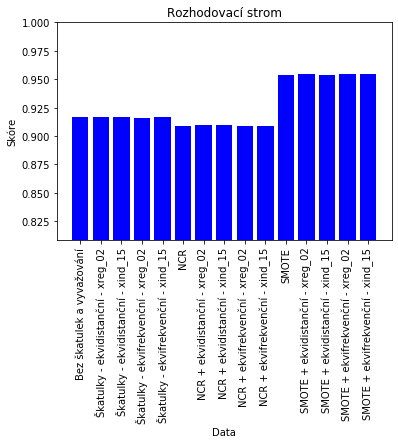

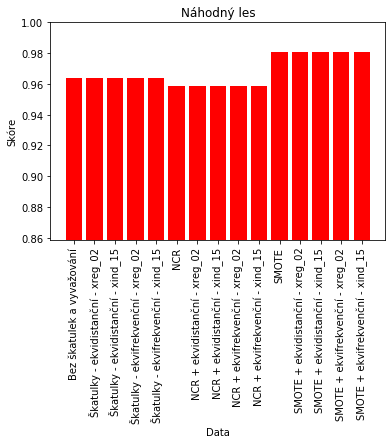

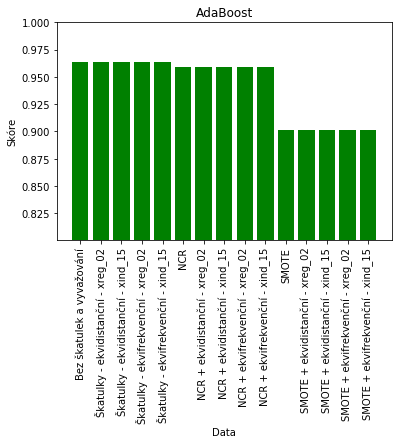

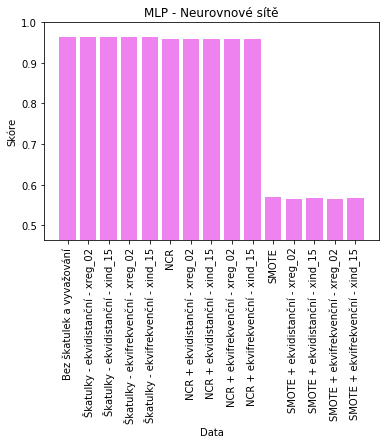

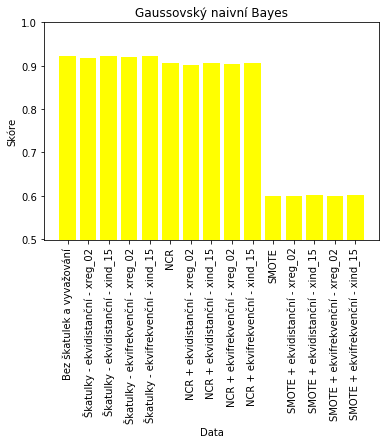

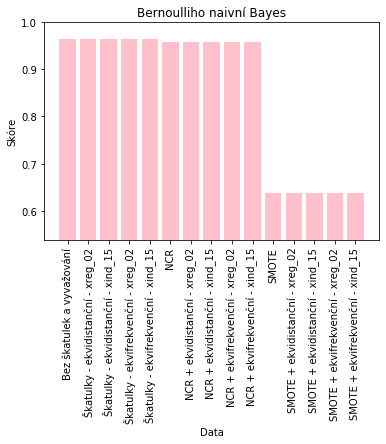

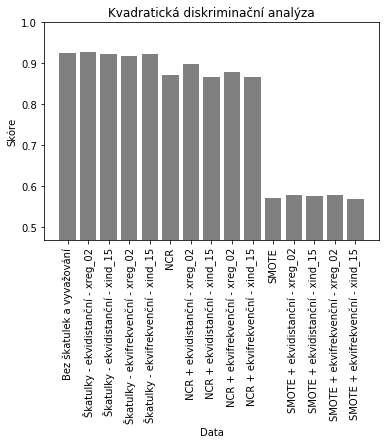

In [33]:
#4.2
colors = ["blue", "red", "green", "violet", "yellow", "pink", "gray"]
for i in range(len(names)):
    plt.bar("Metody", names[i], data = df, color = colors[i])
    plt.xlabel("Data")
    plt.xticks(rotation = 90)
    plt.ylabel("Skóre")
    plt.ylim(df[names[i]].min() - 0.1, 1.0)
    plt.title(names[i])
    plt.show()